<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Classes and Objects

In [1]:
# reload external dependencies when they change
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

Choosing a health plan is hard. Let's write some code to help us!

Let's make a couple simplifying assumptions:

- We only care about total health care cost over the whole year (ignoring for instance the fact that expenses will tend to be more evenly distributed for plans with higher premiums and lower coinsurance).
- Total cost is simply premiums + expenses up to a deductible + coinsurance rate * expenses exceeding a deductible up to an out-of-pocked max (ignoring many factors such as HSA/FSA availability, prescription drug costs, emergency room costs, embedded vs. non-embedded deductibles, etc.).

**Disclaimer:** This code comes with absolutely no warranty and does not constitute advice of any kind.

I'd like to calculate my total health care cost as a function of the expenses I incur for each plan in the set available to me and then plot the results so that I can see how the plans compare at different expense levels.

I could write a function that takes all of the plan information (premiums, deductible, coinsurance rate, etc.) and an expense level and calculates costs for that plan at that expense level. However, this approach is a little clunky. A typical employer will have just a few plans, but for each plan I will want to calculate costs for maybe a few hundred expense levels, so I will end up passing the same plan information values into the function over and over again.

A more natural approach is to model each health plan as an `object` with a set of *attributes* (premiums, deductible, coinsurance rate, etc.), and to provide a *method* that takes in an expense level and refers to those attributes to calculate total costs.

First I need to define a `class`, which acts as a blueprint for `HealthPlan` objects. The first step is to create an `__init__` method that specifies the inputs that are needed to characterize an instance of the class.

We could create this class directly in this notebook, but for practice with PyCharm let's do it there and import it here.


```python
class HealthPlan:
    def __init__(
        self, name, deductible, coinsurance_rate, out_of_pocket_max, monthly_premium
    ):
        self.name = name
        self.deductible = deductible
        self.coinsurance_rate = coinsurance_rate
        self.out_of_pocket_max = out_of_pocket_max
        self.monthly_premium = monthly_premium
```

In [3]:
from health_plan import HealthPlan

<img src=../assets/images/class_init.png width=800>

Pythonistas generally use `UpperCamelCase` for class names, as opposed to the `snake_case` that they use for function and variable names.

We can *instantiate* this class (i.e., create an object that belongs to the class) by writing its name with parentheses as if calling a function. Python will then run the class's `__init__` method with the parameters that we pass in.

*Instantiate the `HealthPlan` class*

In [4]:
low_deductible_plan = HealthPlan(
    name="low_deductible_plan",
    deductible=500,
    coinsurance_rate=0.1,
    out_of_pocket_max=1500,
    monthly_premium=116.32,
)

Because of the lines like `self.name = name` in the `__init__` method, we can retrieve the plan information that we passed in.

*Access our `HealthPlan` object's `name` attribute*

In [5]:
low_deductible_plan.name

'low_deductible_plan'

*Access our `HealthPlan` object's `deductible` attribute*

In [6]:
low_deductible_plan.deductible

500

*Access our `HealthPlan` object's `coinsurance_rate` attribute*

In [7]:
low_deductible_plan.coinsurance_rate

0.1

Now let's define a method to calculate costs.


```python
class HealthPlan:
    def __init__(
        self, name, deductible, coinsurance_rate, out_of_pocket_max, monthly_premium
    ):
        self.name = name
        self.deductible = deductible
        self.coinsurance_rate = coinsurance_rate
        self.out_of_pocket_max = out_of_pocket_max
        self.monthly_premium = monthly_premium

    def calculate_costs(self, expenses):
        result = self.monthly_premium * 12
        result += min(self.deductible, expenses)
        if expenses > self.deductible:
            result += min(
                (expenses - self.deductible) * self.coinsurance_rate,
                self.out_of_pocket_max,
            )
        return result
```

<img src=../assets/images/method.png width=800>

Because we changed the class definition, we need to re-initialize our plan.

*Instantiate our revised `HealthPlan` class*

In [8]:
low_deductible_plan = HealthPlan(
    name="low_deductible_plan",
    deductible=500,
    coinsurance_rate=0.1,
    out_of_pocket_max=1500,
    monthly_premium=116.32,
)

*Run `calculate_costs` on our new `HealthPlan` object*

In [9]:
low_deductible_plan.calculate_costs(10_000)

2845.84

Is that number right? It's a little hard to tell because our function is doing multiple things -- calculating total premiums for the year, calculating deductible paid, and calculating amount paid over the deductible. If we delegated each of those subcalculations to another method, then we could test those "helper methods" and gain confidence that our implementation is correct.


```python
class HealthPlan:
    def __init__(
        self, name, deductible, coinsurance_rate, out_of_pocket_max, monthly_premium
    ):
        self.name = name
        self.deductible = deductible
        self.coinsurance_rate = coinsurance_rate
        self.out_of_pocket_max = out_of_pocket_max
        self.monthly_premium = monthly_premium

    def calculate_costs(self, expenses):
        return (
            self.calculate_total_premium()
            + self.calculate_deductible_paid(expenses)
            + self.calculate_coinsurance_paid(expenses)
        )

    def calculate_total_premium(self):
        return self.monthly_premium * 12

    def calculate_deductible_paid(self, expenses):
        return min(self.deductible, expenses)

    def calculate_coinsurance_paid(self, expenses):
        if expenses < self.deductible:
            return 0
        else:
            return min(
                (expenses - self.deductible) * self.coinsurance_rate,
                self.out_of_pocket_max - self.deductible,
            )
```

Now the benefits of using a class really start to shine. Delegating parts of the total cost calculation to helper functions makes it easier to understand what we are doing and to test its correctness. We could do the same thing with individual functions outside of a class, but then we would need to pass the relevant plan information to each function -- for instance, calculate_coinsurance paid would need not only `expenses` but also `deductible`, `coinsurance_rate`, and `out_of_pocket_max` as inputs -- resulting in much more complicated code.

Let's now do some spot checks of our implementation.

*Instantiate our revised `HealthPlan` class*

In [10]:
low_deductible_plan = HealthPlan(
    name="low_deductible_plan",
    deductible=500,
    coinsurance_rate=0.1,
    out_of_pocket_max=1500,
    monthly_premium=120,
)

Monthly premiums should be 12 * 120 = 1,440

*Check our `calculate_total_premium` method*

In [11]:
assert round(low_deductible_plan.calculate_total_premium(), 2) == 1_440

The deductible paid should be the lesser of expenses and $500.

*Check our `calculate_deductible_paid` method with expenses of $500*

In [12]:
assert round(low_deductible_plan.calculate_deductible_paid(500), 2) == 500

*Check our `calculate_deductible_paid` method with expenses over $500*

In [13]:
assert round(low_deductible_plan.calculate_deductible_paid(1_000), 2) == 500

*Check our `calculate_deductible_paid` method with expenses below $500*

In [14]:
assert round(low_deductible_plan.calculate_deductible_paid(200), 2) == 200

Coinsurance paid should be the lesser of the difference between the out of pocket max and the deductible and 10% of the difference between expenses and the deductible.

*Check our `calculate_coinsurance_paid` method with expenses high enough to high `out_of_pocket_max``*

In [15]:
assert (
    round(low_deductible_plan.calculate_coinsurance_paid(1_000_000), 2)
    == low_deductible_plan.out_of_pocket_max - low_deductible_plan.deductible
)

Check our `calculate_coinsurance_paid` method with expenses within deductible

In [16]:
assert round(low_deductible_plan.calculate_coinsurance_paid(500), 2) == 0

*Check our `calculate_coinsurance_paid` method with intermediate expenses*

In [17]:
assert round(low_deductible_plan.calculate_coinsurance_paid(1000), 2) == 50

Total costs should be the sum of premiums, deductible paid, and coinsurance paid.

*Check our `calculate_costs` method with intermediate expenses*

In [18]:
assert round(low_deductible_plan.calculate_costs(1000), 2) == 1_440 + 500 + 50

Now that we have some assurance that our code is correct, we can do our plan comparison.

*Create a second instance of our `HealthPlan` class*

In [19]:
high_deductible_plan = HealthPlan(
    name="high_deductible_plan",
    deductible=2700,
    coinsurance_rate=0,
    out_of_pocket_max=2700,
    monthly_premium=10,
)

*Calculate costs for each plan for expenses between $0 and $15,000 in $100 increments*

In [20]:
expense_levels = range(0, 15_000, 100)
low_deductible_costs = [
    low_deductible_plan.calculate_costs(expenses) for expenses in expense_levels
]
high_deductible_costs = [
    high_deductible_plan.calculate_costs(expenses) for expenses in expense_levels
]

*Plot costs vs. expenses for the two plans*

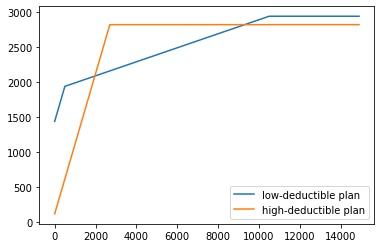

In [21]:
fig, ax = plt.subplots()
ax.plot(expense_levels, low_deductible_costs, label="low-deductible plan")
ax.plot(expense_levels, high_deductible_costs, label="high-deductible plan")
ax.legend()

**Conclusions:**

- The low-deductible plan has lower total costs for the from premiums, deductible payments, and coinsurance payments than the high-deductible plan if expenses are between about \\$2,000 and \\$10,000.
- With less than \\$2,000 in expenses, the high-deductible plan can be quite a bit cheaper.
- Above \\$10,000, the high-deductible plan is slightly cheaper.

## Summary

- Python allows you to define *classes* that act like templates for custom object types.
- Those objects can store data as *attributes* and behavior as *methods*.
- The special method `__init__` runs when you create an instance of a class.
- The first argument to a method of an object is the object itself. Inside the class definition, we call that object `self` and use it to access the class's attributes and methods.
- Turning functions that need access to the same data into methods of a class allows you to attach that data to instances of the class rather than passing it around from function to function.
- Delegating subtasks within a function to "helper functions" yields code that is easier to understand and test.

**Exercise**

*Time:* 10 mins.\
*Format:* Pairs\
*Post answers:* Yes

- Use PyCharm to define a class `Band` with the following features:
    - Attributes:
        - `name`
        - `genre`
        - `albums`
    - Methods:
        - `add_album` -- add an album by name
        - `remove_album` -- remove an album by name
        - `count_albums` -- report how many albums are attributed to the band

```python
class Band:
    def __init__(self, name, genre, albums):
        self.name = name
        self.genre = genre
        self.albums = albums

    def add_album(self, album_name):
        self.albums.append(album_name)

    def remove_album(self, album_name):
        self.albums.remove(album_name)

    def count_albums(self):
        return len(self.albums)
```

In [22]:
from band import Band

In [23]:
# Run this cell to test your code after importing your class
coltrane_quartet = Band(
    name="The John Coltrane Classic Quartet",
    genre="jazz",
    albums=[
        "Ballads",
        "Coltrane",
        "Live at Birdland",
        "Crescent",
        "A Love Supreme",
        "The John Coltrane Quartet Plays",
        "Living Space",
        "Transition",
        "Sun Ship",
        "First Meditations",
        "Kulu Se Mama",
    ],
)

assert coltrane_quartet.name == "The John Coltrane Classic Quartet"
assert coltrane_quartet.genre == "jazz"
assert coltrane_quartet.count_albums() == 11

coltrane_quartet.add_album("Afro Blue Impressions")
assert coltrane_quartet.count_albums() == 12
assert "Afro Blue Impressions" in coltrane_quartet.albums

coltrane_quartet.remove_album("Afro Blue Impressions")
assert coltrane_quartet.count_albums() == 11
assert "Afro Blue Impressions" not in coltrane_quartet.albums

- Make an instance of `Band` that represents a band of your choice. Your list of albums does not need to be comprehensive. Check that all of its attributes have the values you expect and that all of its methods have the effects that you expect, either with `assert` statements as above or just through printing.

In [24]:
# See above for an example

- In PyCharm, define a class `BankAccount` with the following features:
    - Attributes:
        - `owner_name`
        - `balance`
        - `fees_owed`
    - Methods:
        - `deposit` -- add a specified amount to the balance.
        - `withdraw` -- subtract a specified amount from the balance. If the balance goes negative, add \\$20 to `fees_owed`.
        - `pay_fees` -- subtract a specified amount from `fees_owed`.
        
**BONUS:**

- Think about what should happen if `pay_fees` exceeds `fees_owed`, and implement that behavior.
- Handle additional "edge cases," such as negative deposit amounts.


```python
class BankAccount:
    def __init__(self, owner_name, balance, fees_owed):
        self.owner_name = owner_name
        self.balance = balance
        self.fees_owed = fees_owed

    def deposit(self, amount):
        if amount <= 0:
            raise ValueError("Deposit amount must be positive")
        else:
            self.balance += amount

    def withdraw(self, amount):
        if amount <= 0:
            raise ValueError("Withdrawal amount must be positive")
        else:
            self.balance -= amount
        if self.balance < 0:
            self.fees_owed += 20

    def pay_fees(self, amount):
        if amount <= 0:
            raise ValueError("Withdrawal amount must be positive")
        elif amount > self.fees_owed:
            raise ValueError(
                f"Fee payment cannot exceed `fees_owed` amount of {self.fees_owed}"
            )
        else:
            self.fees_owed -= amount
```

- Write your own tests for the `BankAccount` class analogous to the `Band` tests given above.  **BONUS:** Include tests for edges cases such as negative numbers

In [25]:
from bank_account import BankAccount

In [26]:
import pytest


# Run this cell to test your code
sample_account = BankAccount(owner_name="Finley Smith", balance=2000, fees_owed=0)

with pytest.raises(ValueError):
    sample_account.deposit(-10)

with pytest.raises(ValueError):
    sample_account.withdraw(-10)

with pytest.raises(ValueError):
    sample_account.pay_fees(-10)

assert sample_account.owner_name == "Finley Smith"
assert sample_account.balance == 2_000
assert sample_account.fees_owed == 0

sample_account.deposit(500)
assert sample_account.balance == 2_500

sample_account.withdraw(1_000)
assert sample_account.balance == 1_500

sample_account.withdraw(2_000)
assert sample_account.balance == -500

assert sample_account.fees_owed == 20

sample_account.pay_fees(10)
assert sample_account.fees_owed == 10

sample_account.pay_fees(10)
assert sample_account.fees_owed == 0

with pytest.raises(ValueError):
    sample_account.pay_fees(10)